## 뉴럴네트워크 모델 / MNIST

### 사용 패키지

In [1]:
import random
import time

import numpy as np

from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

import json

Using TensorFlow backend.


In [2]:
# Constants & Functions
model_name = 'mnist_nn_3-layers'

def get_hot_idx(arr):
    return arr.index(max(arr))

def save_to_json_file(data, filename):
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)
    print(filename + ' 저장완료')
    
def get_round_array(array, decimal):
    return [round(e, decimal) for e in array]

current_milli_time = lambda: int(round(time.time() * 1000))

### 데이터

In [3]:
# 데이터 관련 파라메터 정의
image_width = 28
image_height = 28
num_of_feature = image_width * image_height

num_of_class = 10
num_of_trainset = 60000
num_of_testset = 10000

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(num_of_trainset, num_of_feature).astype('float32') / 255.0
X_test = X_test.reshape(num_of_testset, num_of_feature).astype('float32') / 255.0
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

### 모델구축

In [4]:
# 모델 구축 
model = Sequential()
model.add(Dense(units=64, input_dim=28*28, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

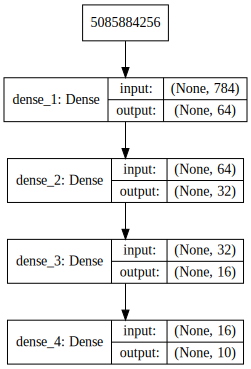

In [5]:
# 구축된 모델 구조 시각화 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 모델 학습

In [6]:
# 모델 피팅
model.fit(X_train, Y_train, epochs=3, batch_size=32)

Epoch 1/3
60000/60000 [==============================] - 4s 67us/step - loss: 0.8029 - acc: 0.7524
Epoch 2/3
60000/60000 [==============================] - 4s 63us/step - loss: 0.3117 - acc: 0.9087
Epoch 3/3
60000/60000 [==============================] - 3s 56us/step - loss: 0.2368 - acc: 0.9311


### 성능 확인

In [7]:
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)

print('loss_and_metrics : ' + str(loss_and_metrics))

10000/10000 [==============================] - 0s 27us/step
loss_and_metrics : [0.20893569509983062, 0.9371]


### 내 데이터로 테스트

In [8]:
print("내 데이터로 테스트")

# 이미지 데이터 로드 (pixel 값 배열)
print("데이터 로드")
with open('./data/mnist_testing/images_not_normal.json') as data_file:
    data = json.load(data_file)
images = np.zeros((len(data), 784))
for i in range(len(data)):
    images[i] = data[i]

# 정답 데이터 로드 
with open('./data/mnist_testing/correctValues.json') as data_file:
    data = json.load(data_file)
correct_vals = np.zeros((len(data), 10))
for i in range(len(data)):
    correct_vals[i] = data[i]

# 결과를 저장할 객체 생성
result = {
    'model_name' : 'neural_network',
    "short_name": "NN",
    'performance' : {},
    'predict' : []
}

# 각 인스턴스 예측
print("각 인스턴스 예측")
cnt_correct = np.zeros(10)
cnt_real = np.zeros(10)
cnt_pred = np.zeros(10)

# 시간 재기 
time_start = current_milli_time()
for i in range(len(images)):
    instance = images[i:i+1]
    real = correct_vals[i].tolist()
    pred_proba = model.predict_proba(instance)[0].tolist()
    real_num = get_hot_idx(real)
    pred_num = get_hot_idx(pred_proba)
    
    cnt_real[real_num] += 1
    cnt_pred[pred_num] += 1
    if real_num is pred_num : 
        cnt_correct[real_num] += 1
        
    result['predict'].append({
        'real': real_num,
        'pred': pred_num,
        'pred_proba': get_round_array(pred_proba, 2)
    })
time_required = current_milli_time() - time_start

result['performance']['required_time'] = time_required
result['performance']['accuracy'] = np.average(cnt_correct)
result['performance']['recall'] = (cnt_correct / cnt_real).tolist()
result['performance']['precision'] = (cnt_correct / cnt_pred).tolist()

print(result['model_name'])
print(result['performance']['required_time'])
print(result['performance']['accuracy'])
print(result['performance']['recall'])
print(result['performance']['precision'])

내 데이터로 테스트
데이터 로드
각 인스턴스 예측
neural_network
3932
922.1
[0.96, 0.951, 0.939, 0.908, 0.96, 0.809, 0.973, 0.915, 0.928, 0.878]
[0.9486166007905138, 0.9684317718940937, 0.9020172910662824, 0.9389865563598759, 0.9022556390977443, 0.9782345828295043, 0.896774193548387, 0.9511434511434511, 0.8197879858657244, 0.9461206896551724]


### 모델 저장

In [9]:
from keras.models import load_model
model.save(model_name+'.h5')

### 예측 결과 저장

In [10]:
# print(result)
save_to_json_file(result, model_name+'__result.json')